In [ ]:
Cell 1: Notebook Setup & Overview

In [1]:
# ============================================================
# 01_data_cleaning_and_eda.ipynb
# ------------------------------------------------------------
# This notebook:
#   1. Loads the raw Glassdoor salary dataset
#   2. Cleans and preprocesses data for modeling
#   3. Generates exploratory visualizations and optional EDA report
# ------------------------------------------------------------
# Output:
#   - data/processed/cleaned_salary_data.csv
#   - app/scaler.pkl
#   - reports/eda_report.html (optional)
#   - logs/data_cleaning_<timestamp>.log
# ============================================================

import pandas as pd
import numpy as np
import os
import joblib
import logging
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # for progress bars

# Optional profiling tool
try:
    from pandas_profiling import ProfileReport
    profiling_available = True
except ImportError:
    profiling_available = False

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


⚙️ Cell 2 — Configuration & Logging Setup

In [2]:
# Directory structure
RAW_PATH = '../data/raw/eda_data.csv'
PROCESSED_PATH = 'data/processed/cleaned_salary_data.csv'
EDA_REPORT_PATH = 'reports/eda_report.html'

# Ensure folders exist
for d in ['data/processed', 'app', 'logs', 'reports']:
    os.makedirs(d, exist_ok=True)

# Logging setup
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = f"logs/data_cleaning_{timestamp}.log"
logging.basicConfig(filename=log_file, level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

print(f"📘 Logging to {log_file}")


📘 Logging to logs/data_cleaning_20251103_150820.log


📥 Cell 3 — Load and Preview Raw Data

In [3]:
df = pd.read_csv(RAW_PATH)
print(f"✅ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

✅ Loaded dataset with 742 rows and 33 columns


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,age,python_yn,R_yn,spark,aws,excel,job_simp,seniority,desc_len,num_comp
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,47,1,0,0,0,1,data scientist,na,2536,0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,36,1,0,0,0,0,data scientist,na,4783,0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,10,1,0,1,0,1,data scientist,na,3461,0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,55,1,0,0,0,0,data scientist,na,3883,3
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,22,1,0,0,0,1,data scientist,na,2728,3


🧰 Cell 4 — Helper Functions (Feature Engineering)

In [4]:
def size_to_num(x):
    """Convert company size text like '1001 to 5000 employees' to numeric midpoint."""
    if isinstance(x, str):
        x = x.lower()
        if 'to' in x:
            try:
                low, high = x.split('to')
                return (int(low.strip()) + int(high.split()[0])) // 2
            except:
                return np.nan
        elif '10000+' in x:
            return 10000
    return np.nan

def rev_to_num(x):
    """Convert revenue ranges like '$1 to $2 billion' → numeric millions."""
    if not isinstance(x, str):
        return np.nan
    x = x.lower()
    try:
        if 'billion' in x:
            nums = [float(s.replace('$','').replace('billion','')) for s in x.split('to') if '$' in s]
            return np.mean(nums) * 1000  # billion → million
        elif 'million' in x:
            nums = [float(s.replace('$','').replace('million','')) for s in x.split('to') if '$' in s]
            return np.mean(nums)
    except:
        return np.nan
    return np.nan


🧹 Cell 5 — Data Cleaning Pipeline

In [5]:
# We use tqdm progress bar for long steps
steps = [
    "Replace missing values & normalize text",
    "Drop irrelevant columns",
    "Convert company size → numeric",
    "Compute company age",
    "Convert revenue → numeric",
    "Encode categorical variables",
    "Scale numeric variables"
]

for step in tqdm(steps, desc="Cleaning Progress"):
    if "missing" in step:
        df.replace(-1, np.nan, inplace=True)
        df = df.map(lambda s: s.lower().strip() if isinstance(s, str) else s)

    elif "Drop" in step:
        drop_cols = ['Unnamed: 0', 'Salary Estimate', 'Job Description', 'Competitors', 'company_txt', 'Company Name']
        df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

    elif "size" in step and 'size' in df.columns:
        df['company_size'] = df['size'].apply(size_to_num)
        df.drop('size', axis=1, inplace=True)

    elif "age" in step and 'founded' in df.columns:
        df['company_age'] = 2025 - df['founded']
        df.drop('founded', axis=1, inplace=True)

    elif "revenue" in step and 'revenue' in df.columns:
        df['revenue_million'] = df['revenue'].apply(rev_to_num)
        df.drop('revenue', axis=1, inplace=True)

    elif "categorical" in step:
        cat_cols = [c for c in ['job_simp','seniority','job_state','type_of_ownership','industry','sector'] if c in df.columns]
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    elif "Scale" in step:
        num_cols = [c for c in ['rating','age','company_age','company_size','revenue_million','desc_len','num_comp','min_salary','max_salary'] if c in df.columns]
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])
        joblib.dump(scaler, 'app/scaler.pkl')

print("✅ Cleaning complete. Rows:", df.shape[0], "| Columns:", df.shape[1])
df.head()


Cleaning Progress:   0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/2y/y2hvbr1n1fq58v3nkk093tkm0000gn/T/ipykernel_72713/2676843079.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda s: s.lower().strip() if isinstance(s, str) else s)


✅ Cleaning complete. Rows: 742 | Columns: 68


,Job Title,Rating,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,...,job_state_or,job_state_pa,job_state_ri,job_state_sc,job_state_tn,job_state_tx,job_state_ut,job_state_va,job_state_wa,job_state_wi
0,data scientist,3.8,"albuquerque, nm","goleta, ca",501 to 1000 employees,1973.0,company - private,aerospace & defense,aerospace & defense,$50 to $100 million (usd),...,False,False,False,False,False,False,False,False,False,False
1,healthcare data scientist,3.4,"linthicum, md","baltimore, md",10000+ employees,1984.0,other organization,health care services & hospitals,health care,$2 to $5 billion (usd),...,False,False,False,False,False,False,False,False,False,False
2,data scientist,4.8,"clearwater, fl","clearwater, fl",501 to 1000 employees,2010.0,company - private,security services,business services,$100 to $500 million (usd),...,False,False,False,False,False,False,False,False,False,False
3,data scientist,3.8,"richland, wa","richland, wa",1001 to 5000 employees,1965.0,government,energy,"oil, gas, energy & utilities",$500 million to $1 billion (usd),...,False,False,False,False,False,False,False,False,True,False
4,data scientist,2.9,"new york, ny","new york, ny",51 to 200 employees,1998.0,company - private,advertising & marketing,business services,unknown / non-applicable,...,False,False,False,False,False,False,False,False,False,False


📊 Cell 6 — Exploratory Data Analysis (Visual)

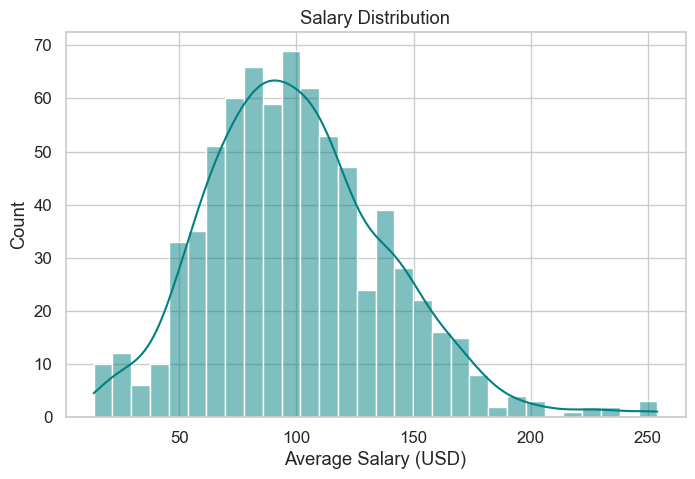

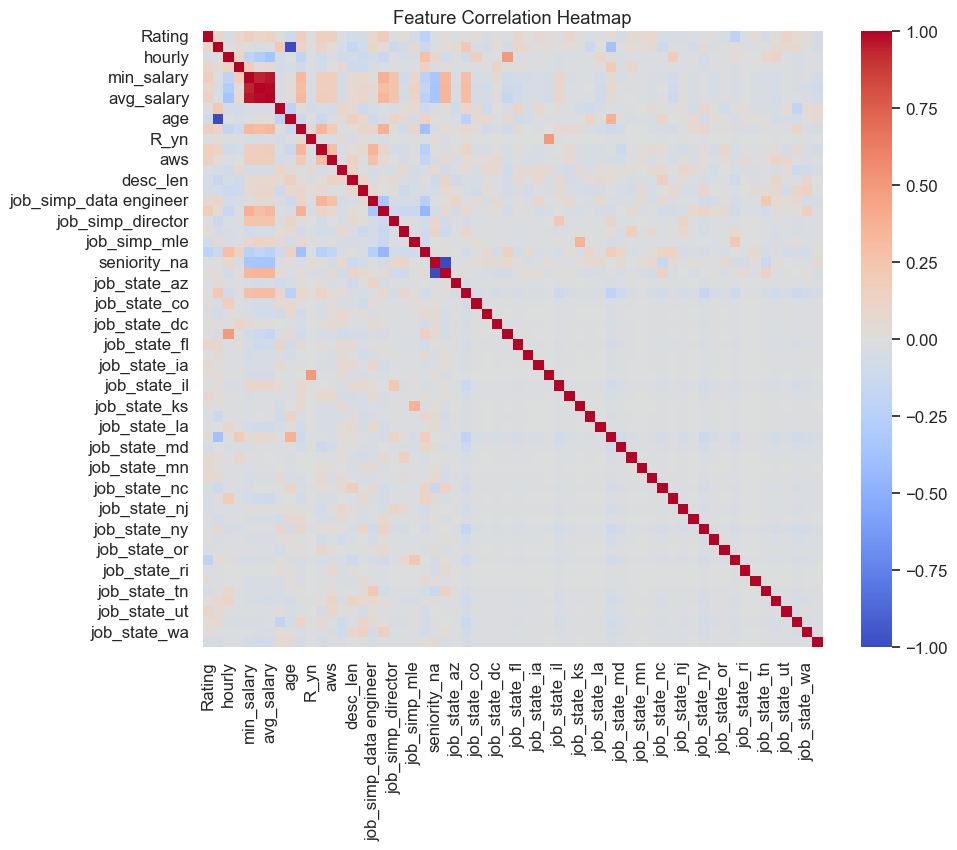

In [6]:
# Salary distribution
plt.figure(figsize=(8,5))
sns.histplot(df['avg_salary'], bins=30, kde=True, color='teal')
plt.title("Salary Distribution")
plt.xlabel("Average Salary (USD)")
plt.show()

# Correlation heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
📈 Cell 7 — Optional: Automatic EDA Report

In [7]:
if profiling_available:
    print("📄 Generating interactive EDA report...")
    profile = ProfileReport(df, title="Salary Dataset EDA Report", minimal=True)
    profile.to_file(EDA_REPORT_PATH)
    print(f"✅ HTML report saved to {EDA_REPORT_PATH}")
else:
    print("⚠️ pandas_profiling not installed — skipping EDA report")


⚠️ pandas_profiling not installed — skipping EDA report


In [ ]:
💾 Cell 8 — Save Cleaned Dataset

In [8]:
df.to_csv(PROCESSED_PATH, index=False)
print(f"✅ Cleaned dataset saved to {PROCESSED_PATH}")


✅ Cleaned dataset saved to data/processed/cleaned_salary_data.csv


In [ ]:
🧮 Cell 9 — Final Checks & Notes

In [9]:
missing_summary = df.isna().sum()
print("🧾 Missing values after cleaning:\n", missing_summary[missing_summary > 0])
print("\nDataset shape:", df.shape)
print("\nNumeric columns scaled:", [c for c in df.columns if any(x in c for x in ['rating','salary','revenue','age'])])
print("\nScaler saved at: app/scaler.pkl")


🧾 Missing values after cleaning:
 Rating     11
Founded    50
age        50
dtype: int64

Dataset shape: (742, 68)

Numeric columns scaled: ['min_salary', 'max_salary', 'avg_salary', 'age', 'job_simp_manager']

Scaler saved at: app/scaler.pkl
